## Binary classification for Heart Disease prediction

### Introduction

In this study, we will test various supervised learning algorithms on the Framingham dataset. This dataset contains various biometric and lifestyle attributes for patients who have tested either postive or negative for Coronary Heart Disease (CHD). 

We will attempt to build a model which successfully predicts the occurence (or not) of CHD based on these attributes.

**Contents**
* [Data importation and cleaning](#data)
* [Data exploration](#exploration)
* [Modelling](#modelling)
* [Dropping attributes](#attributes)
* [Undersampling](#undersampling)
* [Conclustions](#conclusions)


### Data importing and cleaning <a id="data"></a>

First we import the relevant libraries and import the data from the csv vile

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation for big numbers
%matplotlib inline
sns.set()

In [2]:
# Get data
data = pd.read_csv("framingham.csv")
print("Data : " + str(data.shape))

Data : (4240, 16)


In [3]:
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.000,0,0.000,0.000,0,0,0,195.000,106.000,70.000,26.970,80.000,77.000,0
1,0,46,2.000,0,0.000,0.000,0,0,0,250.000,121.000,81.000,28.730,95.000,76.000,0
2,1,48,1.000,1,20.000,0.000,0,0,0,245.000,127.500,80.000,25.340,75.000,70.000,0
3,0,61,3.000,1,30.000,0.000,0,1,0,225.000,150.000,95.000,28.580,65.000,103.000,1
4,0,46,3.000,1,23.000,0.000,0,0,0,285.000,130.000,84.000,23.100,85.000,85.000,0


Let's have a very quick look at the distributions of the data to get a first impression.

We create a grid of plots to do this 

/home/mainaminor/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mainaminor/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


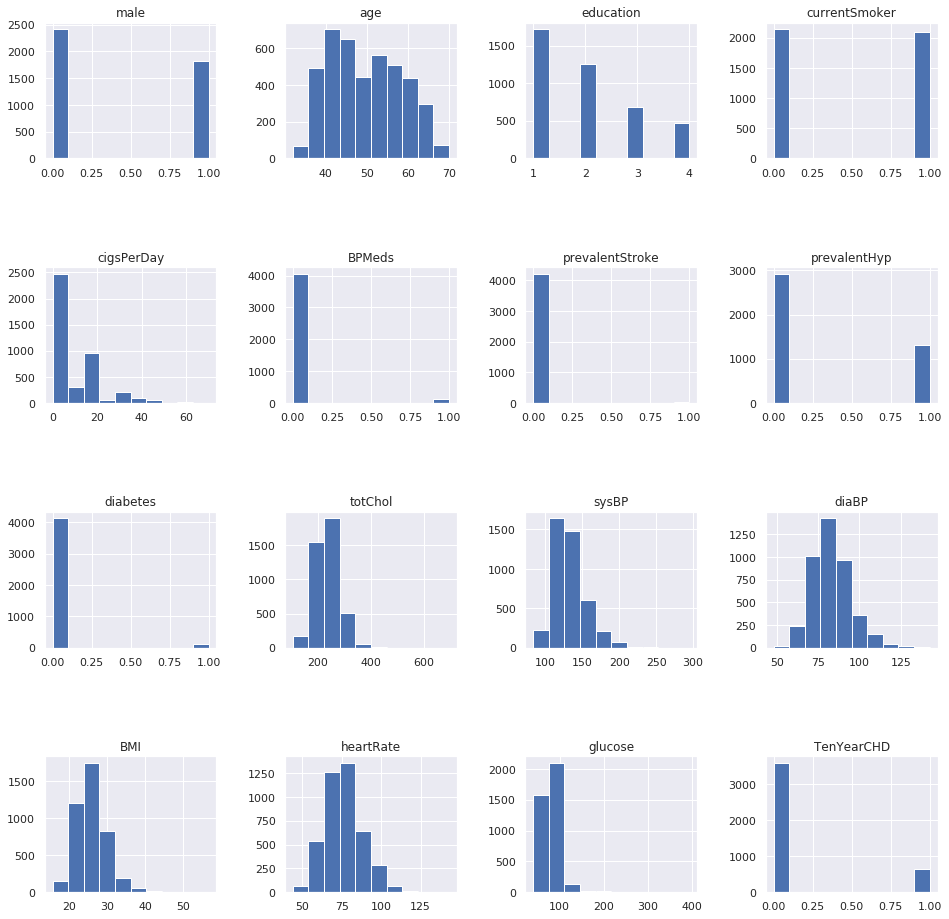

In [4]:
fig, ax = plt.subplots(4,4, figsize=(16, 16))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

for i in range(len(data.columns)):
    plt.subplot(4,4,i+1)
    t=data.columns[i]
    plt.hist(data[t])
    plt.title(t)
plt.show()


We can instantly see from this picture which data types are discrete categorical (e.g. diabetes, prevalentHyp), and which are continuous (e.g. heartRate, BMI). 

Now we check for null values

In [5]:
for i in range(len(data.columns)):
    if sum(pd.isnull(data[data.columns[i]]))>0:
        print([data.columns[i], data[data.columns[i]].dtypes, sum(pd.isnull(data[data.columns[i]]))])

['education', dtype('float64'), 105]
['cigsPerDay', dtype('float64'), 29]
['BPMeds', dtype('float64'), 53]
['totChol', dtype('float64'), 50]
['BMI', dtype('float64'), 19]
['heartRate', dtype('float64'), 1]
['glucose', dtype('float64'), 388]


We have found null values in 7 of the 16 attributes. 

Let's replace the null values with the median value. This is generally more robust than using mean, which can be distorted by significant outliers.

In [6]:
#replace null values for numerical features with median (more robust than simple mean)

data.loc[:, "education"] = data.loc[:, "education"].fillna(data.education.median())
data.loc[:, "cigsPerDay"] = data.loc[:, "cigsPerDay"].fillna(data.cigsPerDay.median())
data.loc[:, "totChol"] = data.loc[:, "totChol"].fillna(data.totChol.median())
data.loc[:, "BMI"] = data.loc[:, "BMI"].fillna(data.BMI.median())
data.loc[:, "BPMeds"] = data.loc[:, "BPMeds"].fillna(data.BPMeds.median())
data.loc[:, "heartRate"] = data.loc[:, "heartRate"].fillna(data.heartRate.median())
data.loc[:, "glucose"] = data.loc[:, "glucose"].fillna(data.glucose.median())

In [7]:
#Final inspection for features containing at least one null value

for i in range(len(data.columns)):
    if sum(pd.isnull(data[data.columns[i]]))>0:
        print([data.columns[i], data[data.columns[i]].dtypes, sum(pd.isnull(data[data.columns[i]]))])

Finally, on a relatively minor house-keeping point, let's check under what types the data is being stored. 

In [8]:
data.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

Notice that "education", "cigsPerDay" and "BPMeds" are stored as float data type. 

"education" and "BPMeds" seem to be numerical from the histograms. "cigsPerDay" could also be argued to be an integer, since it is not expected that anybody would report a fraction of a cigarette.

Let's go ahead and change these to integers.

In [9]:
data.loc[:, "education"] = data.loc[:, "education"].astype("int")
data.loc[:, "cigsPerDay"] = data.loc[:, "cigsPerDay"].astype("int")
data.loc[:, "BPMeds"] = data.loc[:, "BPMeds"].astype("int")

In [10]:
data.dtypes

male                 int64
age                  int64
education            int64
currentSmoker        int64
cigsPerDay           int64
BPMeds               int64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

We are now ready to explore our data in more detail

### Data exploration <a id="exploration"></a>

We begin by specifying the dependent variable (TenYearCHD) separately from the independent variable.

In [11]:
factors=list(data.columns)[0:-1]

**Correlation matrix**

A correlation matrix will not only show the strength of the correlation with the dependent variable, but also the relationships between the independent variables themselves. 

To visualise the correlation matrix, we will create 2 plots:

- a simple bar plot focused on correlations of independent variables vs TenYearCHD
- a heatmap showing all correlations, including those between independent variables


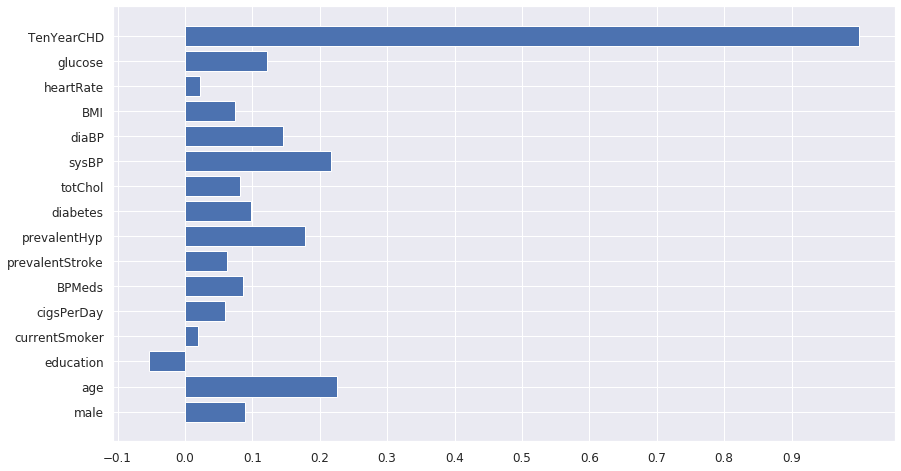

In [12]:
#define variable to be plotted
corrmat=data.corr()

from matplotlib.pyplot import figure
figure(figsize=(14,8))
plt.barh(data.columns,corrmat["TenYearCHD"][:])
plt.tick_params(labelsize=12)
plt.xticks(np.arange(-0.1, 1, 0.1))
plt.show()

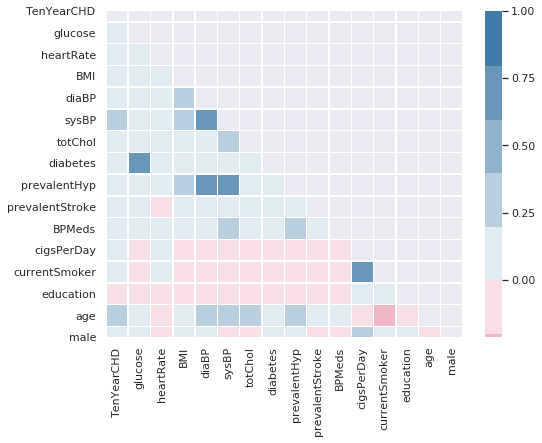

In [13]:
#define colour map
c_map=sns.diverging_palette(1,240, n=10)

f,ax = plt.subplots(figsize=(8,6))

#define masked area of heatmap
mask = np.zeros_like(corrmat) # returns numpy array identical in shape to corrmat, filled with zeros
mask[np.triu_indices_from(mask)] = True # takes mask and changes the triangle above the diagonal to 1

#plot heatmap, applying the mask, reversing the order of rows and columns for display purposes
with sns.axes_style("white"):
    ax = sns.heatmap(corrmat[corrmat.columns[::-1]].iloc[::-1], center = 0, linewidths=.5, mask=mask, cmap=c_map)

From this, we make a few observations:

- The correlations with the dependent variable are generally very week (see additional chart below). Age and sysBP show the strongest correlations, and even these are not particularly strong.

- There are a few strong interdependencies apparent: sysBP/diaBP; diabetes/glucose, and currentSmoker/cigsPerDay

**KDE plots**

In addition to computing explicit correlation indices, we can visualise the influence of  the independent variables by creating  distribution plots. 

For each independent variable, we would create two distribution plots: one for the cases where CHD is observed, and one where it is not. Then we would see the extent to which these plots overlap. 

If there is high overlap, it is implied that the independent variable in question has very little correlation with the dependent variable. If the two plots are significantly shifted vs one another, this suggests a significant correlation. 

For this we will use Kernel Density Estimate (KDE) plots. These could be conceptualised as histograms where a line has been drawn through the top of each bar, and the area underneath each curve has been normalised to 1.

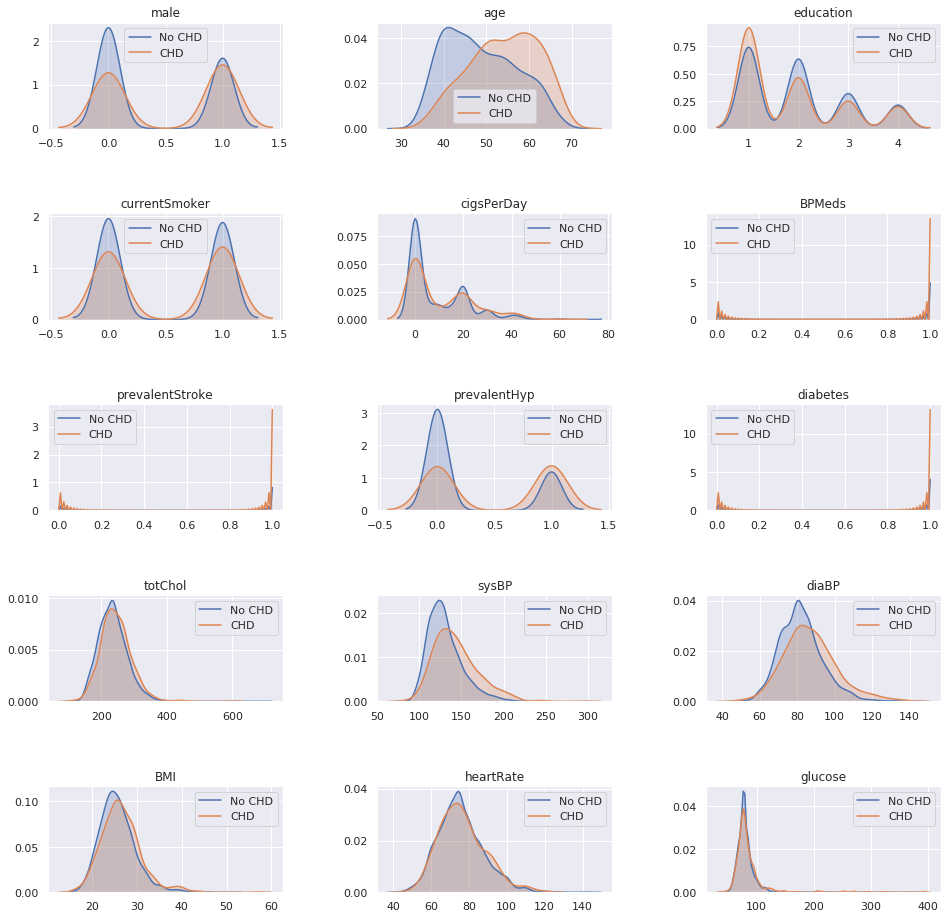

In [14]:
fig, ax = plt.subplots(5,3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

for i in range(len(factors)):
    plt.subplot(5,3,i+1)
    t=factors[i]
    sns.kdeplot(data[t][data.TenYearCHD==0], shade=True, label='No CHD')
    sns.kdeplot(data[t][data.TenYearCHD==1], shade=True, label='CHD')
    plt.title(t)
plt.show()


Again here we see a stronger correlation for "age", "sysBP" and "diaBP", based on comparing the area occupied by the two plots. We can also see the weaker correlations for "totChol", "BMI" and "education". 

Finally, for "heartRate", we see that the two distributions sit almost exactly on top of each other, suggesting an exceedingly weak correlation. 

Notice that in the KDE plots, the function seemed to struggle creating "clean" KDEs for "BPMeds", "prevalentStroke" and "diabetes". Looking more closely at the data, this happens because these are binary variables which are heavily skewed to one value (0 in all cases). 

Let's zoom into this with a more traditional bar chart. 

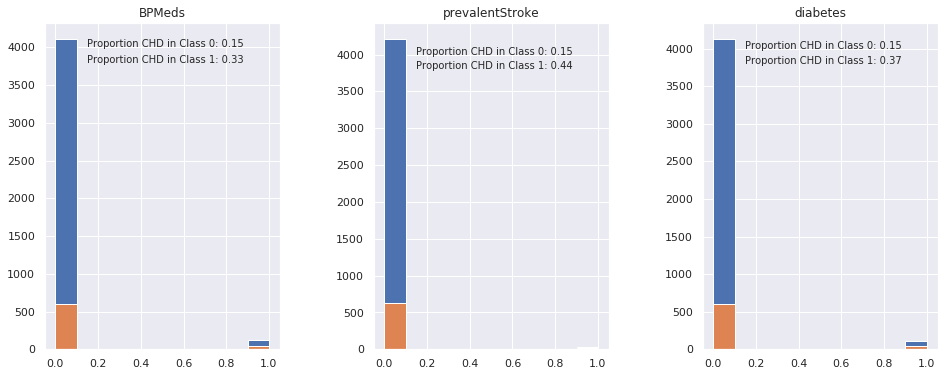

In [15]:
fig, ax = plt.subplots(1,3, figsize=(16, 6))
plt.subplots_adjust(hspace=0.8, wspace=0.4)
factors_zoom=["BPMeds","prevalentStroke", "diabetes"]

for i in range(len(factors_zoom)):
    plt.subplot(1,3,i+1)
    t=factors_zoom[i]
    plt.hist(data[t], bins=10, label="No CHD")
    plt.hist(data[t][(data["TenYearCHD"]==1)], bins=10, label="CHD")
    plt.title(t)
    plt.text(0.15, 4000, 
             "Proportion CHD in Class 0: {}".format(round(data.groupby([t, "TenYearCHD"]).count().male[0][1]/data.groupby([t, "TenYearCHD"]).count().male[0].sum(),2)),            
            )
    plt.text(0.15, 3800, 
             "Proportion CHD in Class 1: {}".format(round(data.groupby([t, "TenYearCHD"]).count().male[1][1]/data.groupby([t, "TenYearCHD"]).count().male[1].sum(),2)),            
            )
plt.show()


For these variables,  only a tiny proportion of the observations had a value of 1 for the variable in question. This presents a challenge, we could expect that the information being gained 

### Modelling <a id="modelling"></a>

We are now ready to model. Let's begin by preparing the data for the classification models by defining X, y, and the train/test split.

In [16]:
#define X for our dataset
X = np.asarray(data[factors])

#define y for our dataset
y = np.asarray(data['TenYearCHD'])

In [17]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3392, 15) (3392,)
Test set: (848, 15) (848,)


Now let's import our various supervised learning algorithms. 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

Finally, lets run our predictions and assess the result. 

We will be focused on the following key metrics:

- __Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

- __Recall__ is true positive rate. It is defined as: Recall =  TP / (TP + FN)

- __The F1 score__ is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

__Note__: The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem in machine learning models.
__C__ parameter indicates __inverse of regularization strength__ which must be a positive float. Smaller values specify stronger regularization. 
Now lets fit our model with train set:

In [20]:
#Logistic Regression
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)

#Support Vector Machine
svm = SVC(gamma="auto").fit(X_train, y_train)
yhat_svm = svm.predict(X_test)

#Decision Tree Classifier
dtc_up = DecisionTreeClassifier().fit(X_train, y_train)
yhat_dtree = dtc_up.predict(X_test)

#K Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors = 2).fit(X_train, y_train)
yhat_knn = knn.predict(X_test)

In [21]:
print ("Logistic regression")
print (classification_report(y_test, yhat))
print ("F1 score", round(f1_score(y_test, yhat), 3))
print ("")
print ("")
print ("SVM")
print (classification_report(y_test, yhat_svm))
print ("F1 score", round(f1_score(y_test, yhat_svm),3))
print ("")
print ("")
print ("Decision Tree")
print (classification_report(y_test, yhat_dtree))
print ("F1 score", round(f1_score(y_test, yhat_dtree),3))
print ("")
print ("")
print ("KNN")
print (classification_report(y_test, yhat_knn))
print ("F1 score", round(f1_score(y_test, yhat_knn),3))
print ("")

Logistic regression
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       719
           1       0.38      0.07      0.12       129

    accuracy                           0.84       848
   macro avg       0.61      0.52      0.52       848
weighted avg       0.78      0.84      0.79       848

F1 score 0.118


SVM
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       719
           1       0.67      0.02      0.03       129

    accuracy                           0.85       848
   macro avg       0.76      0.51      0.47       848
weighted avg       0.82      0.85      0.78       848

F1 score 0.03


Decision Tree
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       719
           1       0.21      0.25      0.22       129

    accuracy                           0.74       848
   macro avg       0.53      0.54      0.53       848
wei

Notice the following key features of the result:

- **For the null case** (CHD=0), precision is uniformly much higher than for the non-null prediction. In other words, our modell is very accurate when it makes the call that a patient does **not** have heart disease. Recall  is also very good, meaning the model is doing a good job at catching a large proportion of true non-null cases. 

- **For the non-null case** (ie CHD =1) the results are quite poor. This means the model is struggling to correctly and accurately identify patients who have CHD. 

- **Overall F1 score** is low across the board; the DecisionTree performs strongest, and SVM the weakest.

Now for a patient, the consequences of a missed diagnosis are far worse than the consequences of a mis-diagnosis, so we need to do better. 

First, we try reducing the number of attributes and seeing how that could help.

### Dropping attributes <a id="attributes"></a>

Let us drop some of the weaker contributors based on the correlation score, and re-run the algorithm.

In [22]:
del_att=["heartRate", "currentSmoker", "prevalentStroke"]
factors_red_col  = [e for e in factors if e not in del_att]

In [23]:
factors_red_col

['male',
 'age',
 'education',
 'cigsPerDay',
 'BPMeds',
 'prevalentHyp',
 'diabetes',
 'totChol',
 'sysBP',
 'diaBP',
 'BMI',
 'glucose']

In [24]:
#define X for our dataset
X_red_col = np.asarray(data[factors_red_col])

In [25]:
X_red_col = preprocessing.StandardScaler().fit(X_red_col).transform(X_red_col)

In [26]:
X_train_red_col, X_test_red_col, y_train, y_test = train_test_split( X_red_col, y, test_size=0.2, random_state=4)
print ('Train set:', X_train_red_col.shape,  y_train.shape)
print ('Test set:', X_test_red_col.shape,  y_test.shape)

Train set: (3392, 12) (3392,)
Test set: (848, 12) (848,)


In [27]:
#Logistic Regression
LR_red_col = LogisticRegression(C=0.001, solver='liblinear').fit(X_train_red_col,y_train)
yhat_red_col = LR_red_col.predict(X_test_red_col)

#Support Vector Machine
svm_red_col = SVC(gamma="auto").fit(X_train_red_col, y_train)
yhat_svm_red_col = svm_red_col.predict(X_test_red_col)

#Decision Tree Classifier
dtc_up_red_col = DecisionTreeClassifier().fit(X_train_red_col, y_train)
yhat_dtree_red_col = dtc_up_red_col.predict(X_test_red_col)

#K Nearest Neighbors Classifier
knn_red_col = KNeighborsClassifier(n_neighbors = 2).fit(X_train_red_col, y_train)
yhat_knn_red_col = knn_red_col.predict(X_test_red_col)

In [28]:
print ("Logistic regression")
print (classification_report(y_test, yhat_red_col))
print ("F1 score", round(f1_score(y_test, yhat_red_col), 3))
print ("")
print ("")
print ("SVM")
print (classification_report(y_test, yhat_svm_red_col))
print ("F1 score", round(f1_score(y_test, yhat_svm_red_col),3))
print ("")
print ("")
print ("Decision Tree")
print (classification_report(y_test, yhat_dtree_red_col))
print ("F1 score", round(f1_score(y_test, yhat_dtree_red_col),3))
print ("")
print ("")
print ("KNN")
print (classification_report(y_test, yhat_knn_red_col))
print ("F1 score", round(f1_score(y_test, yhat_knn_red_col),3))
print ("")

Logistic regression
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       719
           1       0.33      0.06      0.10       129

    accuracy                           0.84       848
   macro avg       0.59      0.52      0.51       848
weighted avg       0.77      0.84      0.79       848

F1 score 0.105


SVM
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       719
           1       0.50      0.02      0.03       129

    accuracy                           0.85       848
   macro avg       0.67      0.51      0.47       848
weighted avg       0.80      0.85      0.78       848

F1 score 0.03


Decision Tree
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       719
           1       0.19      0.22      0.20       129

    accuracy                           0.73       848
   macro avg       0.52      0.52      0.52       848
wei

We see some improvement, but this is marginal at best. 

**Dropping weaker attributes has not significantly improved prediction outcomes**

Let's try a different tactic, undersampling.

### Undersampling <a id="undersampling"></a>

For binary classification models, it turns out that having a significantly larger proportion of null observations results in the ML algorithm leaning towards null results when it makes its prediction.

In other words, since we fed the algorithm a data-set where the vast majority of cases do not have CHD, it is (naturally?) producing results which are decidedly sanguine about the occurence of CHD.

Undersampling is a step where we artificially modify the training dataset so that there is a comparable or equal proportion of null vs non-null observations. 

Lets perform this procedure and review the results.

In [29]:
# Shuffle data
data_shuff = data.sample(frac=1,random_state=4)

# Put all the CHD cases in a separate dataset.
CHD_data = data_shuff.loc[data_shuff['TenYearCHD'] == 1]

#Randomly select 492 observations from the non-CHD case (majority class)
non_CHD_trunc = data_shuff.loc[data_shuff['TenYearCHD'] == 0].sample(n=644,random_state=42)

# Concatenate both dataframes again
data_red = pd.concat([CHD_data, non_CHD_trunc]).sample(frac=1, random_state=2)
data_red.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3967,1,42,2,1,30,0,0,1,0,270.000,129.500,100.000,30.130,82.000,88.000,1
1636,1,44,4,0,0,0,0,0,0,211.000,130.000,85.500,26.980,60.000,82.000,0
1302,0,63,1,0,0,0,0,1,0,226.000,172.500,98.000,26.470,87.000,81.000,0
653,1,57,1,1,10,0,0,1,0,250.000,148.000,91.000,27.600,88.000,103.000,0
3780,0,64,2,1,20,0,0,1,0,282.000,142.000,82.000,24.020,78.000,78.000,0


In [30]:
#define X for our dataset
X_red = np.asarray(data_red[factors])
y_red = np.asarray(data_red['TenYearCHD'])

#scale X
X_red = preprocessing.StandardScaler().fit(X_red).transform(X_red)

In [31]:
#Logistic Regression - note we train using the full set of the "reduced" dataset
LR_red = LogisticRegression(C=0.001, solver='liblinear').fit(X_red,y_red)
yhat_red = LR_red.predict(X_test)

#Support Vector Machine
svm_red = SVC(gamma="auto").fit(X_red,y_red)
yhat_svm_red = svm_red.predict(X_test)

#Decision Tree Classifier
dtc_up_red = DecisionTreeClassifier().fit(X_red,y_red)
yhat_dtree_red = dtc_up_red.predict(X_test)

#K Nearest Neighbors Classifier
knn_red = KNeighborsClassifier(n_neighbors = 2).fit(X_red,y_red)
yhat_knn_red = knn_red.predict(X_test)

In [32]:
print ("Logistic regression")
print (classification_report(y_test, yhat_red))
print ("F1 score", round(f1_score(y_test, yhat_red), 3))
print ("")
print ("")
print ("SVM")
print (classification_report(y_test, yhat_svm_red))
print ("F1 score", round(f1_score(y_test, yhat_svm_red),3))
print ("")
print ("")
print ("Decision Tree")
print (classification_report(y_test, yhat_dtree_red))
print ("F1 score", round(f1_score(y_test, yhat_dtree_red),3))
print ("")
print ("")
print ("KNN")
print (classification_report(y_test, yhat_knn_red))
print ("F1 score", round(f1_score(y_test, yhat_knn_red),3))
print ("")

Logistic regression
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       719
           1       0.24      0.72      0.36       129

    accuracy                           0.60       848
   macro avg       0.58      0.65      0.54       848
weighted avg       0.82      0.60      0.66       848

F1 score 0.357


SVM
              precision    recall  f1-score   support

           0       0.94      0.53      0.68       719
           1       0.24      0.81      0.37       129

    accuracy                           0.58       848
   macro avg       0.59      0.67      0.52       848
weighted avg       0.83      0.58      0.63       848

F1 score 0.368


Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.57      0.71       719
           1       0.24      0.78      0.37       129

    accuracy                           0.60       848
   macro avg       0.59      0.67      0.54       848
we

The result is a marked improvement. 

The top F1 score is now 0.43, from the KNN algorithm, with Logistic regression, Decision Tree and SVM algorithms each achieving a score of 0.36-0.37.

However, note that for the non-null predictions, recall is above 0.7 for all of Logistic Regression, Decision Tree and SVM methods, meaning these are giving a better likelihood that a patient with CHD will successfully be identified.

### Conclusion

Although we have demonstrated the impact of undersampling to improve the quality of binary classification predictions, the weakness of the correlation and the low overall F1 scores suggest that more could be done to improve the quality of the data fed to the model. 

For instance, collecting a larger volume of data on patients who are positive for CHD relative to the overall sample; or considering additional lifestyle or biometric attributes to collect. 